Integral in consideration

* <big> $ y = \displaystyle \int_a^b  \displaystyle \frac{1}{\sqrt{1 + x^2}} \, dx$ </big>, where $a = 3$ and $b = 4$

### 1. Computer value analytically

In [18]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [2]:
def integral(a,b):
    return np.log(b + np.sqrt(b**2 + 1**2)) - np.log(a + np.sqrt(a**2 + 1**2))

print('Integral Value:', integral(a = 3,b = 4))

Integral Value: 0.2762660880290344


### 2. Compute integral value using trapezoidal rule

In [3]:
def trapezoidal(function, a, b, n):
    
    h = (b-a)/float(n)
    s = 0.5*(function(a) + function(b))
    
    for i in range(1,n,1):
        s = s + function(a + i*h)
    
    value = h*s
    
    return value

def function(x):
    return 1/(np.sqrt(1 + x**2))

print('Integral Value:', trapezoidal(function, a = 3, b = 4, n = 10000))

Integral Value: 0.27626608806053443


In [4]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438381 sha256=1e7da1fdaaa3fa70274d7a2f4d03aaa5599f12a1a10c01e6d6e30a28f1ec1865
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


### 3. Parallelize using MPI. You should be able to choose any number of MPI processes regardless of the number of discretization points

In [10]:
%%writefile mpi_trapizoidal_integral.py

from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def trapezoidal(function, a, b, n, h):

    s = 0.5*(function(a) + function(b))
    
    for i in range(1,n,1):
        s = s + function(a + i*h)
    
    value = h*s
    
    return value

def function(x):
    return 1/(np.sqrt(1 + x**2))

def Get_data(rank, size, comm):
    a=None
    b=None
    n=None
    if rank == 0:
        a = 3
        b = 4
        n = 10000
        
    a=comm.bcast(a)
    b=comm.bcast(b)
    n=comm.bcast(n)
    return a,b,n

a,b,n = Get_data(rank, size, comm)

h = (b-a)/n # step size for trapezoidal rule is common for all processes

mpi_n = int(n/size) # number of trapezoids/size is also same variable for all calls 


mpi_a = a + rank*mpi_n*h
mpi_b = mpi_a + mpi_n*h
integral = trapezoidal(function, mpi_a, mpi_b, mpi_n, h)

total=comm.reduce(integral)

if (rank == 0):
    print(f'for n = {n} trapezoids the integral from {a} to {b} for our defined function = {total}')
    
MPI.Finalize

Overwriting mpi_trapizoidal_integral.py


In [12]:
t = time()
!mpirun --allow-run-as-root -n 2 python mpi_trapizoidal_integral.py
print('time:', time()-t, 'seconds')

for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0.2762660880605352
time: 0.7303202152252197 seconds


### 4. Plot the speedup vs number of processors

In [22]:
times = []
for i in range(1,10):
    t = time()
    !mpiexec --allow-run-as-root -n {i} python mpi_trapizoidal_integral.py
    times.append((time()-t)/i)
    print(f'running time per process with : {i}: is {times[-1]}')

for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0.27626608806053443
running time per process with : 1: is 0.5212469100952148
for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0.2762660880605352
running time per process with : 2: is 0.3623732328414917
for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0.27624183421268933
running time per process with : 3: is 0.34167106946309406
for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0.2762660880605354
running time per process with : 4: is 0.3074508309364319
for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0.2762660880605353
running time per process with : 5: is 0.30640416145324706
for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0.2761690692448581
running time per process with : 6: is 0.2726982831954956
for n = 10000 trapezoids the integral from 3 to 4 for our defined function = 0

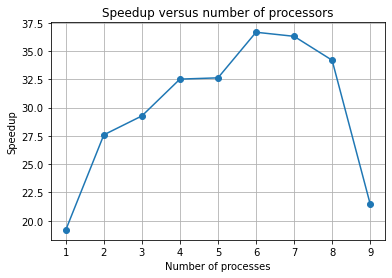

In [24]:
plt.subplot()
plt.plot(range(1,10), [1/i*10 for i in times],'o-')
plt.title('Speedup versus number of processors')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid()

plt.show()

### 5. Plot integration error vs the discretization size

Text(0.5, 0, 'n')

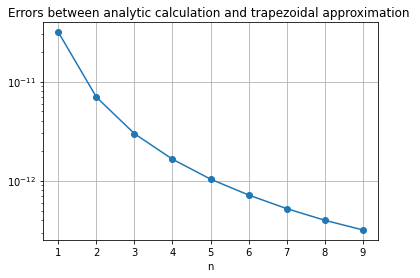

In [34]:
errors = []
for i in np.linspace(10000, 100000, 9):
    errors.append(trapezoidal(function, 3, 4, int(i)) - integral(3, 4))
plt.yscale('log')    
plt.plot(range(1,10), errors,'o-')
plt.grid()
plt.title('Errors between analytic calculation and trapezoidal approximation ')
plt.xlabel('n')

error decreases with discritization size as expected because we're taking closer points to estimate the integral